In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import cv2
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

In [9]:
class KDE():
    def __init__(self, kernel_type='gaussian'):
        self.kernel_type    = kernel_type
        self.bandwidth      = None
        self.X              = None

    def __kernel_function(self, X):
        if self.kernel_type == 'box':
            return np.where(np.abs(X) <= 1, 0.5, 0)
        elif self.kernel_type == 'gaussian':
            return 1 / (np.sqrt(2 * np.pi)) * np.exp(-0.5 * X**2)
        elif self.kernel_type == 'triangular':
            return np.where(np.abs(X) <= 1, 1 - np.abs(X), 0)

    def __pseudo_likelihood(self, bandwidth):
        diffs               = self.X - self.X[:, None]
        non_zero_diff_mask  = ~np.eye(self.X.shape[0], dtype=bool)
        non_zero_diffs      = diffs[non_zero_diff_mask, :].reshape(self.X.shape[0], self.X.shape[0] - 1, self.X.shape[1])

        kernel_output       = self.__kernel_function(non_zero_diffs / bandwidth)

        p_n_x_n             = np.mean(np.sum(kernel_output, axis=1), axis=1) / bandwidth

        pseudo_likelihood   = np.mean(np.log(p_n_x_n, where=p_n_x_n > 0))

        return -pseudo_likelihood

    def __get_bandwidth(self):
        initial_bandwidth   = np.std(self.X) * (4 / (3 * self.X.shape[0]))**0.2
        optimization_result = minimize(self.__pseudo_likelihood, initial_bandwidth, bounds=((1e-5, None),))
        optimial_bandwidth  = optimization_result.x[0]

        return optimial_bandwidth

    def fit(self, X):
        self.X          = X[..., None] if X.ndim == 1 else X
        self.bandwidth  = self.__get_bandwidth()

    def get_density(self, X):
        X               = X.reshape(-1, self.X.shape[1])
        diffs           = X[:, None] - self.X
        kernel_output   = self.__kernel_function(diffs / self.bandwidth)

        density         = np.sum(np.sum(kernel_output, axis=1), axis=1) / (self.X.shape[0] * self.bandwidth)

        return density

    def plot_pdf(self, X, ax=None, fig=None):
        if X.ndim == 1:
            X       = X.reshape(-1, self.X.shape[1])
            density = self.get_density(X)

            if ax is None:
                plt.hist(self.X, bins=50, density=True, color='orange', ec='black')
                plt.plot(X, density, color='green', lw=3)
                plt.title(f'KDE Plot of 1D Data with {self.kernel_type} Kernel and Bandwidth {np.round(self.bandwidth, 3)}')
                plt.show()
            else:
                ax.hist(self.X, bins=50, density=True, color='orange', ec='black')
                ax.plot(X, density, color='green', lw=3)
                ax.set_title(f'KDE Plot of 1D Data with {self.kernel_type} Kernel and Bandwidth {np.round(self.bandwidth, 3)}')

        elif X.ndim == 2:
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            positions = np.vstack([xx.ravel(), yy.ravel()])
            
            densities = np.reshape(self.get_density(positions.T), xx.shape)

            if ax is None:
                plt.contourf(xx, yy, densities, cmap='Greens', levels=50, alpha=0.7)
                plt.scatter(self.X[:, 0], self.X[:, 1], color='orange', alpha=0.5)
                plt.xlim(x_min, x_max)
                plt.ylim(y_min, y_max)
                plt.title(f'KDE Plot of 2D Data with {self.kernel_type} Kernel and Bandwidth {np.round(self.bandwidth, 3)}')
                plt.colorbar()
                plt.show()
            else:
                contour = ax.contourf(xx, yy, densities, cmap='Greens', levels=50, alpha=0.7)
                ax.scatter(self.X[:, 0], self.X[:, 1], color='orange', alpha=0.5)
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                ax.set_title(f'KDE Plot of 2D Data with {self.kernel_type} Kernel and Bandwidth {np.round(self.bandwidth, 3)}')
                fig.colorbar(contour, ax=ax)

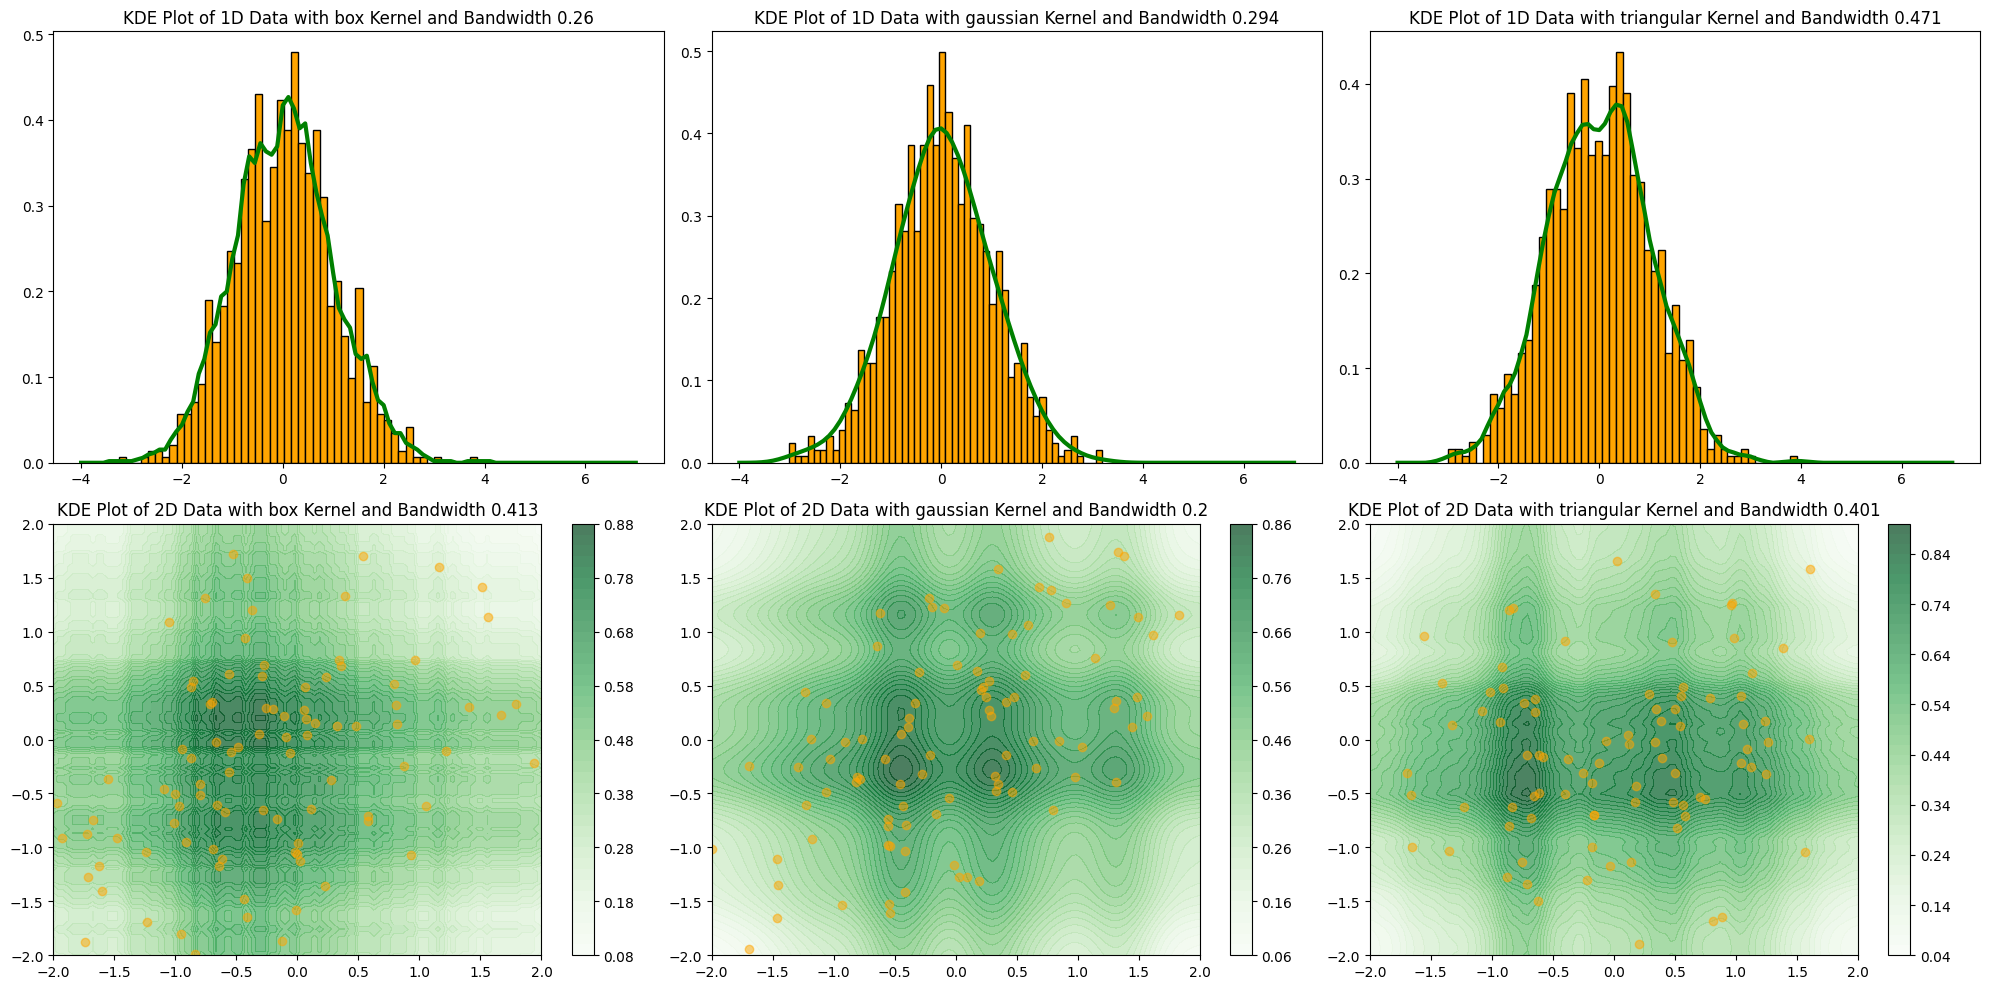

In [43]:
np.random.seed(42)

kernels  = ['box', 'gaussian', 'triangular']
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, kernel in enumerate(kernels):
    normal_1d = np.random.normal(loc=0, scale=1, size=1000)
    kde       = KDE(kernel_type=kernel)
    kde.fit(normal_1d)
    
    test_data_1d = np.linspace(-4, 7, 100)
    kde.plot_pdf(test_data_1d, ax=axs[0, i], fig=fig)

    normal_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]], size=100)
    kde       = KDE(kernel_type=kernel)
    kde.fit(normal_2d)

    x_2d = np.linspace(-2, 2, 100)
    y_2d = np.linspace(-2, 2, 100)
    X_2d, Y_2d = np.meshgrid(x_2d, y_2d)

    test_data_2d    = np.vstack([X_2d.ravel(), Y_2d.ravel()]).T
    kde.plot_pdf(test_data_2d, ax=axs[1, i], fig=fig)

fig.tight_layout()

In [10]:
def get_coordinates(cell_value):
    x,y = json.loads(cell_value)
    return int(x),int(y)

def create_dataframe(image_number):
    initial_data = pd.read_csv(f"Bounding-Boxes/CSV/TLBR_{image_number}.csv")
    column_names = [
        {'name': 'Id'},
        {'name':'Top-Left'},
        {'name':'Bottom-Right'},
        {'name': 'Top'},
        {'name': 'Left'},
        {'name': 'Bottom'},
        {'name': 'Right'},
        {'name': 'Top_Box'},
        {'name': 'Bottom_Box'},
        {'name': 'Left_Box'},
        {'name': 'Right_Box'},
        {'name':'Center'},
    ]
    euclidean = pd.DataFrame(columns=['Id','Top-Left','Bottom-Right','Top','Left','Bottom','Right','Center','Top_Box','Bottom_Box','Left_Box','Right_Box'])
    for index, row in initial_data.iterrows():
        bottom_right = get_coordinates(row['Bottom-Right'])
        bottom_right_x , bottom_right_y = bottom_right[0],bottom_right[1]
        top_left = get_coordinates(row['Top-Left'])
        top_left_x , top_left_y = top_left[0],top_left[1]
        bounding_box_id =  row['Id']
        Top = np.array([(top_left_x+bottom_right_x)/2,top_left_y])
        Left = np.array([top_left_x,(top_left_y+bottom_right_y)/2])
        Bottom = np.array([(top_left_x+bottom_right_x)/2,bottom_right_y])
        Right = np.array([bottom_right_x,(top_left_y+bottom_right_y)/2])
        Center = np.array([(top_left_x+bottom_right_x)//2,(top_left_y+bottom_right_y)//2])
        Top_box , Bottom_box , Left_box , Right_box = np.array([-1,0]),np.array([-1,0]) , np.array([-1,0]), np.array([-1,0])
        euclidean.loc[index] = [bounding_box_id,np.array(top_left),np.array(bottom_right),Top,Left,Bottom,Right,Center,Top_box,Bottom_box,Left_box,Right_box]
    return euclidean

In [11]:
def get_horizontal_distances(df):
    hdists = []
    for _, data in df.iterrows():
        neighbour_dists = []

        for _, data_2 in df.iterrows():
            c1 = data['Center']
            c2 = data_2['Center']

            dist = np.linalg.norm(c1 - c2)
            neighbour_dists.append(dist)

        closest_neighbours = np.argsort(neighbour_dists)[1:7]

        for neighbour in closest_neighbours:
            hdist = np.min(np.abs([data['Left'][0] - df.loc[neighbour]['Right'][0], data['Right'][0] - df.loc[neighbour]['Left'][0], 
                                   data['Left'][0] - df.loc[neighbour]['Left'][0], data['Right'][0] - df.loc[neighbour]['Right'][0]]))
            hdists.append(hdist)

    return np.array(hdists)

def get_vertical_distances(df):
    vdists = []
    for _, data in df.iterrows():
        neighbour_dists = []

        for _, data_2 in df.iterrows():
            c1 = data['Center']
            c2 = data_2['Center']

            dist = np.linalg.norm(c1 - c2)
            neighbour_dists.append(dist)    

        closest_neighbours = np.argsort(neighbour_dists)[1:7]

        for neighbour in closest_neighbours:
            vdist = np.min(np.abs([data['Top'][1] - df.loc[neighbour]['Bottom'][1], data['Bottom'][1] - df.loc[neighbour]['Top'][1], 
                                   data['Top'][1] - df.loc[neighbour]['Top'][1], data['Bottom'][1] - df.loc[neighbour]['Bottom'][1]]))
            vdists.append(vdist)

    return np.array(vdists)

In [12]:
def plot_results(img_num, kernel_type='box', bandwidth=None):
    result_df = create_dataframe(img_num)
    result_img = cv2.cvtColor(cv2.imread(f"Bounding-Boxes/images/{img_num}.jpg"), cv2.COLOR_BGR2RGB)
    hkde = KDE(kernel_type=kernel_type)
    hdists = get_horizontal_distances(result_df)
    hkde.fit(hdists)
    h_threshold = np.percentile(hdists, 90)
    print(f"Horizontal threshold: {h_threshold}")
    print(f"Computed horizontal bandwidth: {hkde.bandwidth}")
    if bandwidth is not None:
        hkde.bandwidth = bandwidth
        print(f"Bandwidth hyperparameter value: {bandwidth}")
    print()

    vkde = KDE(kernel_type=kernel_type)
    vdists = get_vertical_distances(result_df)
    vkde.fit(vdists)
    v_threshold = np.percentile(vdists, 40)
    print(f"Vertical threshold: {v_threshold}")
    print(f"Computed vertical bandwidth: {vkde.bandwidth}")
    if bandwidth is not None:
        vkde.bandwidth = bandwidth
        print(f"Bandwidth hyperparameter value: {bandwidth}")
    print()

    for i, data in result_df.iterrows():
        cv2.rectangle(result_img, (int(data['Top-Left'][0]),int(data['Top-Left'][1])), (int(data['Bottom-Right'][0]),int(data['Bottom-Right'][1])), (255,0,0), 2)
        for j, data_2 in result_df.iterrows():
            if i != j:
                left_minimum = np.min(np.abs([data['Left'][0] - data_2['Right'][0],data['Left'][0] - data_2['Left'][0]]))
                right_minimum = np.min(np.abs([data['Right'][0] - data_2['Left'][0],data['Right'][0] - data_2['Right'][0]]))
                top_minimum = np.min(np.abs([data['Top'][1] - data_2['Bottom'][1],data['Top'][1] - data_2['Top'][1]]))
                bottom_minimum = np.min(np.abs([data['Bottom'][1] - data_2['Top'][1],data['Bottom'][1] - data_2['Bottom'][1]]))
                h_dist = np.min(np.abs([left_minimum,right_minimum]))
                v_dist = np.min(np.abs([top_minimum,bottom_minimum]))
                if h_dist <= h_threshold and v_dist <= v_threshold:
                    cv2.line(result_img, (data['Center'][0],data['Center'][1]), (data_2['Center'][0],data_2['Center'][1]), (0, 255, 0), 2)

    _, axs = plt.subplots(1, 3, figsize=(21, 7))

    test_dists = np.linspace(min(hdists), max(hdists), 1000)
    test_densities = hkde.get_density(test_dists)
    axs[0].plot(test_dists, test_densities)
    axs[0].axvline(h_threshold, color='red', ls='--', label='Horizontal threshold')
    axs[0].set_title(f'Horizontal density - {kernel_type} kernel - {np.round(hkde.bandwidth, 3) if bandwidth is None else np.round(bandwidth, 3)} bandwidth')
    axs[0].legend()

    test_dists = np.linspace(min(vdists), max(vdists), 1000)
    test_densities = vkde.get_density(test_dists)
    axs[1].plot(test_dists, test_densities)
    axs[1].axvline(v_threshold, color='red', ls='--', label='Vertical threshold')
    axs[1].set_title(f'Vertical density - {kernel_type} kernel - {np.round(vkde.bandwidth, 3) if bandwidth is None else np.round(bandwidth, 3)} bandwidth')
    axs[1].legend()

    axs[2].imshow(result_img)
    axs[2].axis('off')
    axs[2].set_title('Resulting document structure')
    plt.show()

Horizontal threshold: 51.0
Computed horizontal bandwidth: 5.000067127857725

Vertical threshold: 10.0
Computed vertical bandwidth: 7.000021238698569

[338 133] [469 185]
[662 126] [795 178]
[822 133] [923 185]
[592 250] [694 314]
[735 253] [846 308]
[1112  133] [1136  181]
[1170  123] [1286  191]
[1325  130] [1443  181]
[1636  123] [1774  174]
[1791  130] [1893  181]
[2076  123] [2212  185]
[1346  250] [1455  304]
[1474  246] [1537  321]
[1576  260] [1665  325]
[1714  246] [1893  308]
[1931  243] [2042  308]
[2079  243] [2183  321]
[1339  321] [1530  396]
[1537  328] [1631  393]
[1639  332] [1767  383]
[1774  328] [1830  390]
[1849  328] [1963  383]
[1980  325] [2025  390]
[2033  321] [2183  400]
[1450  479] [1542  561]
[1569  479] [1663  561]
[1682  479] [1769  561]
[1820  482] [1931  547]
[1963  485] [2059  550]
[2074  482] [2183  547]
[1341  557] [1462  636]
[1479  557] [1578  636]
[1598  561] [1733  622]
[1755  561] [1815  622]
[1839  564] [1953  619]
[1977  557] [2042  636]
[2059 

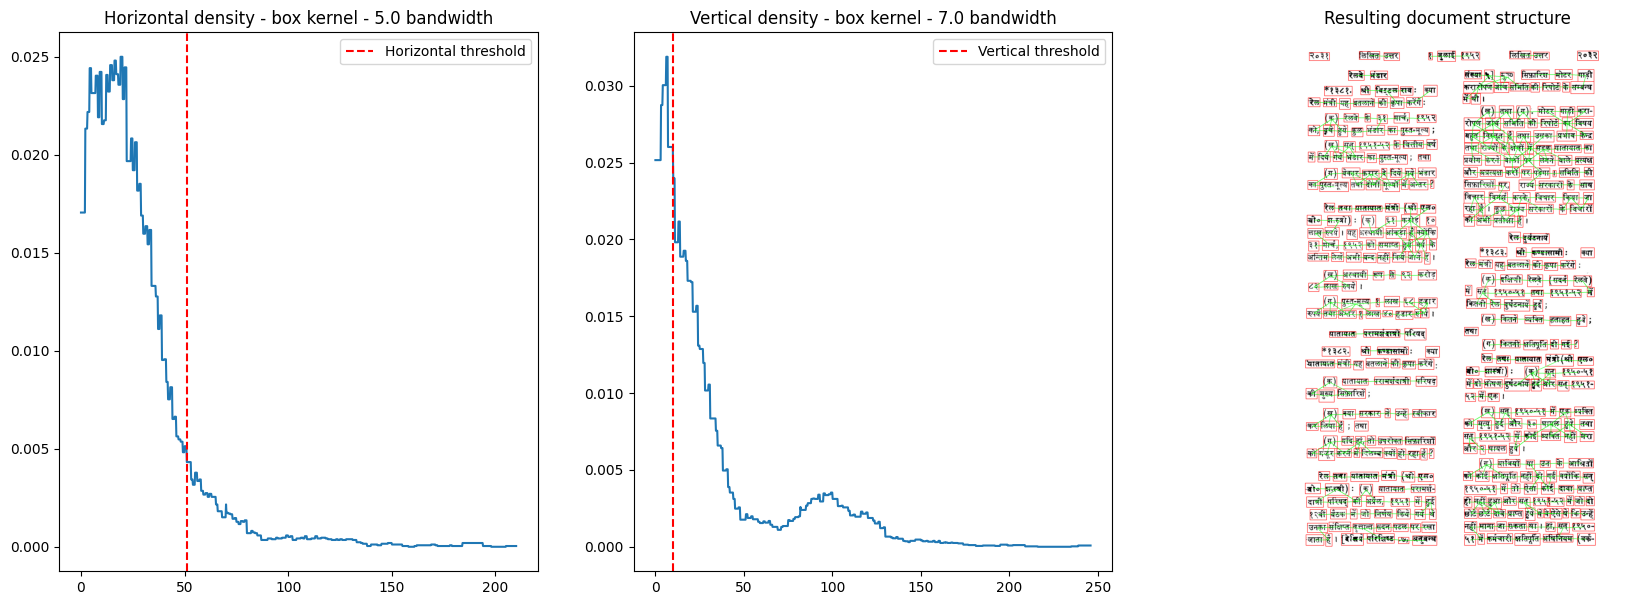

In [78]:
plot_results(29)

In [ ]:
hyperparam_imgs = [29, 145, 174, 250]
bandwidths = [10, 15]
kernels = ['box', 'gaussian', 'triangular']

for i, kernel in enumerate(kernels):
    for j, bandwidth in enumerate(bandwidths):
        print("===============================================")
        print(f"Kernel: {kernel} - Bandwidth: {bandwidth}")
        print("===============================================")
        plot_results(hyperparam_imgs[(i * 2 + j) % 4], kernel_type=kernel, bandwidth=bandwidth)

In [4]:
def make_connections(image,euclidean):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])
      
      # print(bottom_adjacent_id)
      
      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id-1].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id-1].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id-1].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id-1].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

In [16]:
def create_dataframe_previous(image_number):
    initial_data = pd.read_csv(f"Bounding-Boxes/CSV/TLBR_{image_number}.csv")
    column_names = [
        {'name': 'Id'},
        {'name':'Top-Left'},
        {'name':'Bottom-Right'},
        {'name': 'Top'},
        {'name': 'Left'},
        {'name': 'Bottom'},
        {'name': 'Right'},
        {'name': 'Top_Box'},
        {'name': 'Bottom_Box'},
        {'name': 'Left_Box'},
        {'name': 'Right_Box'}
    ]
    euclidean = pd.DataFrame(columns=[col['name'] for col in column_names])
    column_names = [
        {'name': 'Id'},
        {'name': 'Centre'}
    ]
    center_data = pd.DataFrame(columns=[col['name'] for col in column_names])
    def get_coordinates(cell_value):
        x,y = json.loads(cell_value)
        return int(x),int(y)

    for index, row in initial_data.iterrows():
        bottom_right_x , bottom_right_y = get_coordinates(row['Bottom-Right'])
        top_left_x , top_left_y = get_coordinates(row['Top-Left'])
        bounding_box_id =  row['Id']
        Top , Bottom , Left , Right = (
            ((top_left_x + bottom_right_x) / 2, top_left_y),
            ((top_left_x + bottom_right_x) / 2, bottom_right_y),
            (top_left_x, (top_left_y + bottom_right_y) / 2),
            (bottom_right_x, (top_left_y + bottom_right_y) / 2)
        )
        Top_box , Bottom_box , Left_box , Right_box = (-1,0),(-1,0),(-1,0),(-1,0)
        euclidean.loc[index] = [bounding_box_id,(top_left_x,top_left_y),(bottom_right_x,bottom_right_y),Top,Left,Bottom,Right,Top_box,Bottom_box,Left_box,Right_box]
        center_data.loc[index] = [bounding_box_id,[(bottom_right_x+top_left_x)/2,(bottom_right_y+top_left_y)/2]]
    center_data[['X','Y']] = pd.DataFrame(center_data['Centre'].tolist(), columns=['X', 'Y'])
    def get_distance(z1, z2):
        return np.sqrt((z2[0] - z1[0]) ** 2 + (z2[1] - z1[1]) ** 2)

    def find_closest_bounding_box(direction,reference_row):
        closest_bounding_box = [-1,0]
        minimum_distance = float('inf')
        for index,closest_row in euclidean.iterrows():
            if closest_row['Id'] == reference_row['Id']:
                continue
            distance = float('inf')
            calc = get_distance([(reference_row['Top'][0] + reference_row['Bottom'][0]) / 2, (reference_row['Top'][1] + reference_row['Bottom'][1]) / 2],
                                        [(closest_row['Top'][0] + closest_row['Bottom'][0]) / 2, (closest_row['Top'][1] + closest_row['Bottom'][1]) / 2])
            if direction == 'Top' and reference_row['Top'][1] < closest_row['Bottom'][1]:
                distance = calc
            elif direction == 'Bottom' and reference_row['Bottom'][1] > closest_row['Top'][1]:
                distance = calc
            elif direction == 'Left' and reference_row['Left'][0] < closest_row['Right'][0]:
                distance = calc
            elif direction == 'Right' and reference_row['Right'][0] > closest_row['Left'][0]:
                distance = calc
            if minimum_distance > distance:
                minimum_distance = distance
                closest_bounding_box = [minimum_distance, closest_row['Id'] + 1]
        return closest_bounding_box

    vertical_distances = []
    horizontal_distances = []
    for index, row in euclidean.iterrows():
        euclidean.at[index, 'Top_Box'] = find_closest_bounding_box('Top',row)
        euclidean.at[index, 'Bottom_Box'] = find_closest_bounding_box('Bottom',row)
        euclidean.at[index, 'Left_Box'] = find_closest_bounding_box('Left',row)
        euclidean.at[index, 'Right_Box'] = find_closest_bounding_box('Right',row)

        if euclidean.at[index, 'Top_Box'][0] != -1:
            vertical_distances.append(euclidean.at[index, 'Top_Box'][0])
        if euclidean.at[index, 'Left_Box'][0] != -1:
            horizontal_distances.append(euclidean.at[index, 'Left_Box'][0])
    clustering = dendrogram(linkage(center_data[['X', 'Y']], method='single', metric='minkowski'), 
                        labels=center_data['Id'].tolist(), 
                        orientation='top', 
                        distance_sort='ascending',no_plot=True)
    cluster_id_mapping = {}
    cluster_labels = fcluster(linkage(center_data[['X', 'Y']], method='single', metric='minkowski'), t=5, criterion='distance')  # Adjust the threshold 't' as needed
    cluster_id_mapping = {id_: label for id_, label in zip(clustering['ivl'], cluster_labels)}
    unique_colors = set(clustering['color_list'])
    num_unique_colors = len(unique_colors)
    for color in unique_colors:
        ids_in_cluster = [id_ for id_, label_color in zip(clustering['ivl'], clustering['color_list']) if label_color == color]
        cluster_id = cluster_id_mapping.get(ids_in_cluster[0], None)  # Get cluster ID from the mapping
        cluster_centers = center_data[center_data['Id'].isin(ids_in_cluster)]
    vertical_distances.sort()
    horizontal_distances.sort()
    coordinates = euclidean[['Top', 'Bottom']].values
    centroids = [(np.mean([top[0], bottom[0]]), np.mean([top[1], bottom[1]])) for top, bottom in coordinates]
    wcss = []
    for num_clusters in range(1, 25):
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(centroids)
        wcss.append(kmeans.inertia_)
    values = horizontal_distances
    window_length = 5
    polyorder = 2
    smoothed_values = savgol_filter(values, window_length, polyorder)
    z_scores = zscore(smoothed_values)
    outlier_threshold = 3
    non_outlier_indices = np.where(np.abs(z_scores) <= outlier_threshold)
    non_outlier_values = [values[i] for i in non_outlier_indices[0]]
    second_derivative = np.diff(np.diff(non_outlier_values))
    elbow_index = np.argmax(second_derivative) + 2 
    optimal_value = values[elbow_index - 1] 
    values = vertical_distances
    values = values[10:-10]
    window_length = 5
    polyorder = 2
    smoothed_values = savgol_filter(values, window_length, polyorder)
    z_scores = zscore(smoothed_values)
    outlier_threshold = 1.5
    non_outlier_indices = np.where(np.abs(z_scores) <= outlier_threshold)
    non_outlier_values = [values[i] for i in non_outlier_indices[0]]
    second_derivative = np.diff(np.diff(non_outlier_values))
    elbow_index = np.argmax(second_derivative) + 2 
    optimal_value1 = values[elbow_index - 1] 
    for index, row in euclidean.iterrows():
        if(euclidean.at[index, 'Top_Box'][0] >= optimal_value1):
            euclidean.at[index, 'Top_Box'][1] = 0
            euclidean.at[index, 'Top_Box'][0] = -1
        if(euclidean.at[index, 'Bottom_Box'][0] >= optimal_value1):
            euclidean.at[index, 'Bottom_Box'][1] = 0
            euclidean.at[index, 'Bottom_Box'][0] = -1
        if(euclidean.at[index, 'Left_Box'][0] >= optimal_value):
            euclidean.at[index, 'Left_Box'][0] = -1
            euclidean.at[index, 'Left_Box'][1] = 0
        if(euclidean.at[index, 'Right_Box'][0] >= optimal_value):
            euclidean.at[index, 'Right_Box'][1] = 0
            euclidean.at[index, 'Right_Box'][0] = -1
    return euclidean

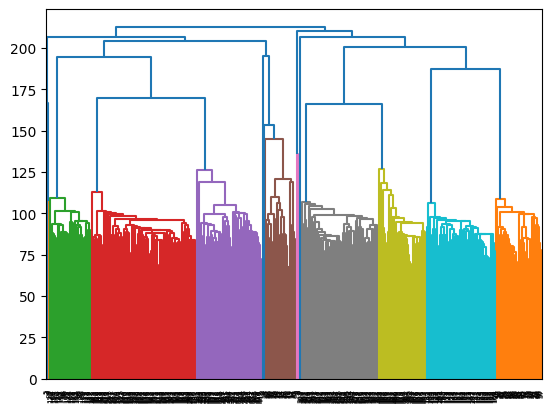

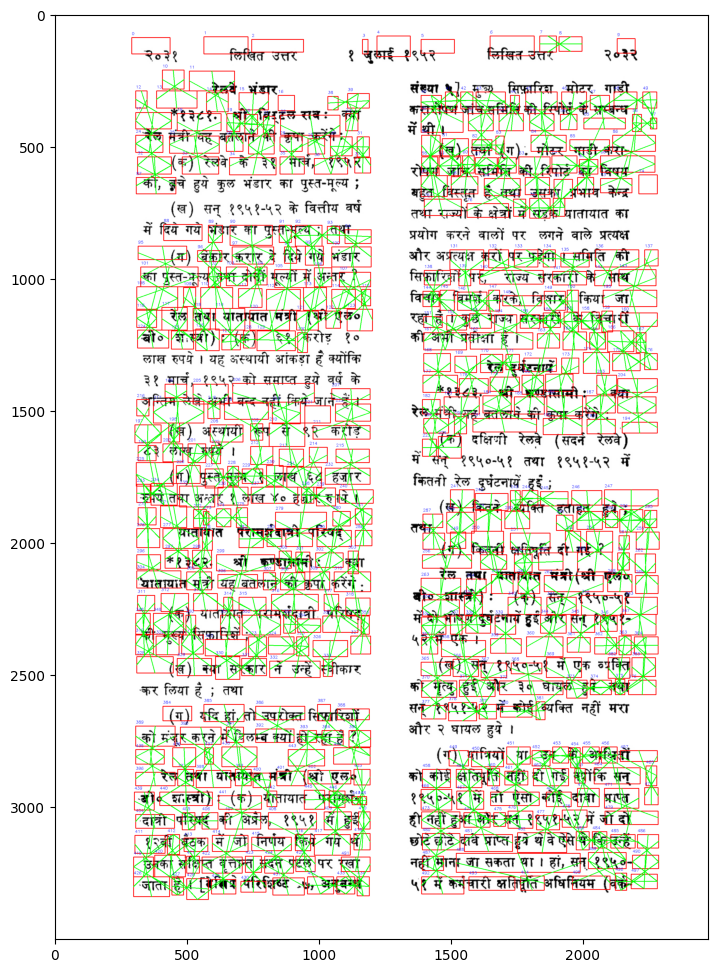

In [6]:
img = cv2.imread('Bounding-Boxes/images/29.jpg')
euclidean = create_dataframe_previous(68)
plt.figure(figsize=(20,12))
plt.imshow(make_connections(img,euclidean))

In [17]:
from scipy.cluster.hierarchy import linkage, fcluster

def plot_comparision(img_num):
    result_df = create_dataframe(img_num)
    result_img = cv2.cvtColor(cv2.imread(f"Bounding-Boxes/images/{img_num}.jpg"), cv2.COLOR_BGR2RGB)

    hkde = KDE(kernel_type='box')
    hdists = get_horizontal_distances(result_df)
    hkde.fit(hdists)
    hkde.bandwidth = 10
    h_threshold = np.percentile(hdists, 90)

    vkde = KDE(kernel_type='box')
    vdists = get_vertical_distances(result_df)
    vkde.fit(vdists)
    vkde.bandwidth = 15
    v_threshold = np.percentile(vdists, 40)

    for i, data in result_df.iterrows():
        cv2.rectangle(result_img, (int(data['Top-Left'][0]),int(data['Top-Left'][1])), (int(data['Bottom-Right'][0]),int(data['Bottom-Right'][1])), (255,0,0), 2)
        for j, data_2 in result_df.iterrows():
            if i != j:
                h_dist = np.min(np.abs([data['Left'][0] - data_2['Right'][0], data['Right'][0] - data_2['Left'][0], 
                                        data['Left'][0] - data_2['Left'][0], data['Right'][0] - data_2['Right'][0]]))
                v_dist = np.min(np.abs([data['Top'][1] - data_2['Bottom'][1], data['Bottom'][1] - data_2['Top'][1], 
                                        data['Top'][1] - data_2['Top'][1], data['Bottom'][1] - data_2['Bottom'][1]]))

                if h_dist <= h_threshold and v_dist <= v_threshold:
                    cv2.line(result_img, (int(data['Center'][0]),int(data['Center'][1])), (int(data_2['Center'][0]),int(data_2['Center'][1])), (0, 255, 0), 2)

    
    _, axs = plt.subplots(1, 2, figsize=(16, 9))
    axs[0].imshow(result_img)
    axs[0].axis('off')
    axs[0].set_title('KDE Output')
    img = cv2.imread('Bounding-Boxes/images/29.jpg')
    euclidean = create_dataframe_previous(68)
    axs[1].imshow(make_connections(img,euclidean))
    axs[1].axis('off')
    axs[1].set_title('Problem 4.2 Output')
    plt.show()

In [ ]:
image_numbers = [29,68,101,145,232,250]
for image_number in image_numbers:
    plot_comparision(image_number)